## Mean / Median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

**Note the following**:

- If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for  numerical variables.
- If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
- For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.


### Which variables can I impute with Mean / Median Imputation?

The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mean / median)

If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)

### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset

When replacing NA with the mean or median, the variance of the variable will be distorted if the number of NA is big respect to the total number of observations, leading to underestimation of the variance.

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected. Mean / median imputation may alter intrinsic correlations since the mean / median value that now replaces the missing data will not necessarily preserve the relation with the remaining variables.

Finally, concentrating all missing values at the mean / median value, may lead to observations that are common occurrences in the distribution, to be picked up as outliers.


### When to use mean / median imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

Although in theory, the above conditions should be met to minimise the impact of this imputation technique, in practice, mean / median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this, is the simplicity of the technique.


## In this demo:

We will learn how to perform mean and median imputation using pandas on the Ames House Price and Titanic Datasets.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

## Titanic

In [3]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('datasets/titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [4]:
# let's look at the percentage of NA

data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

The only variable with missing data is Age, with ~20% of missing observations.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [5]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [6]:
# Let's explore the missing data in the train set
# the percentages should be fairly similar to those
# of the whole dataset

X_train.isnull().mean()

age     0.191048
fare    0.000000
dtype: float64

In [7]:
# let's make a function to fill missing values with the mean or median:
# the variable takes the dataframe, the variable, and the value of the
# mean or median
# and returns the variable with the filled na


def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [8]:
# calculate the median Age

median = X_train.age.median()
median

28.0

In [9]:
# calculate the mean Age

mean = X_train.age.mean()
mean

30.23144399460189

In [10]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
X_train['Age_median'] = impute_na(X_train, 'age', median)

# now replace with the mean
X_train['Age_mean'] = impute_na(X_train, 'age', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
X_train['Age_mean'] = np.round(X_train['Age_mean'], 1)

X_train.head(15)

,age,fare,Age_median,Age_mean
501,13.0,19.5000,13.0,13.0
588,4.0,23.0000,4.0,4.0
402,30.0,13.8583,30.0,30.0
1193,NaN,7.7250,28.0,30.2
686,22.0,7.7250,22.0,22.0
971,NaN,7.8792,28.0,30.2
117,30.0,56.9292,30.0,30.0
540,2.0,26.0000,2.0,2.0
294,49.0,110.8833,49.0,49.0
261,35.0,26.2875,35.0,35.0


Look at the rows with missing data (NaN) in Age, and see how in the new variables those were replaced by either 28 (median) or 30 (mean).

In [11]:
# we can see a change in the variance after mean / median imputation
# this is expected, because the percentage of missing data is quite
# high in Age, ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after median imputation: ', X_train['Age_median'].var())
print('Variance after mean imputation: ', X_train['Age_mean'].var())

Original variable variance:  194.16304666581854
Variance after median imputation:  157.7984295760209
Variance after mean imputation:  157.02170735199397


As expected, the variance is underestimated, because now many values are the same ==> either the mean or the median value.

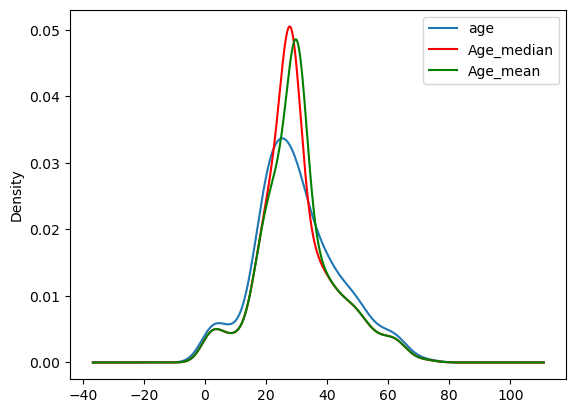

In [12]:
# we can see that the distribution has changed 
# with now more values accumulating towards the median
# or median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Age_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Age_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, the mean / median imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the mean / median values.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

In [13]:
# we also said that mean / median imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_median', 'Age_mean']].cov()

,fare,age,Age_median,Age_mean
fare,2248.326729,136.176223,114.961682,110.198311
age,136.176223,194.163047,194.163047,194.159033
Age_median,114.961682,194.163047,157.798430,157.035694
Age_mean,110.198311,194.159033,157.035694,157.021707


We see indeed that the covariance between Age and Fare is changed after the mean / median imputation.

<AxesSubplot:>

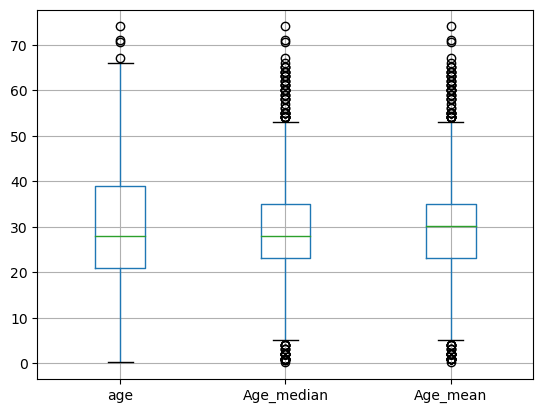

In [14]:
# Finally, I mentioned that mean / median imputation may lead 
# to observations that are normal, to look like outliers

# or in other words, mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
X_train[['age', 'Age_median', 'Age_mean']].boxplot()

From the boxplot above, we can see that after the imputation not only we have more outliers on the higher Age values, but we have now outliers as well for the lower values of Age.

**Is this important?**

If we are after true outliers, we need to keep this behaviour in mind, to make sure that we are neither masking nor creating artificial outliers with our imputation technique. In practice, we normally don't check for this behaviour at all. But I think it is important to know that is happening.

## House Prices Dataset

Let's repeat the exercise in the House Prices dataset from. In this dataset, there are variables with a lot or with few missing data. Therefore we can compare the effect of mean / median imputation in both scenarios.

In [15]:
# we are going to use only the following variables,
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [16]:
# let's load the House Prices dataset

data = pd.read_csv('datasets/houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [17]:
# print the variables that contain missing data

# in the next list comprehension, I loop over all the columns
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum() > 0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [18]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

**Remember that the mean and the median that we will use to replace the NA needs to be calculated in the train set and propagated to the test set.**

In [19]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

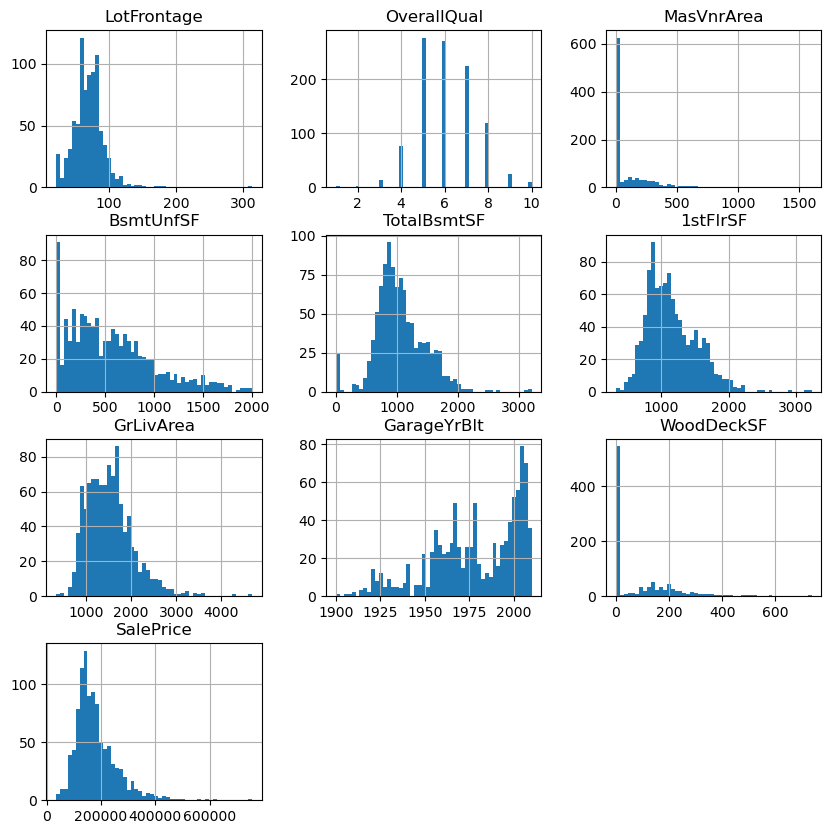

In [20]:
# let's plot the distributions of the variables
# we learnt this code in section 3 on variable characteristics

X_train.hist(bins=50, figsize=(10,10))
plt.show()

In [21]:
# create a new variable with the missing values replaced
# by the median using the function we created above

# I repeat the following lines for each of the variables with NA
# over the next cells

median = X_train['LotFrontage'].median()

X_train.loc[:,'LotFrontage_median'] = impute_na(X_train, 'LotFrontage', median)
X_test.loc[:,'LotFrontage_median'] = impute_na(X_test, 'LotFrontage', median)

In [22]:
median = X_train['MasVnrArea'].median()

X_train.loc[:,'MasVnrArea_median'] = impute_na(X_train, 'MasVnrArea', median)
X_test.loc[:,'MasVnrArea_median'] = impute_na(X_test, 'MasVnrArea', median)

In [23]:
median = X_train['GarageYrBlt'].median()

X_train.loc[:, 'GarageYrBlt_median'] = impute_na(X_train, 'GarageYrBlt', median)
X_test.loc[:,'GarageYrBlt_median'] = impute_na(X_test, 'GarageYrBlt', median)

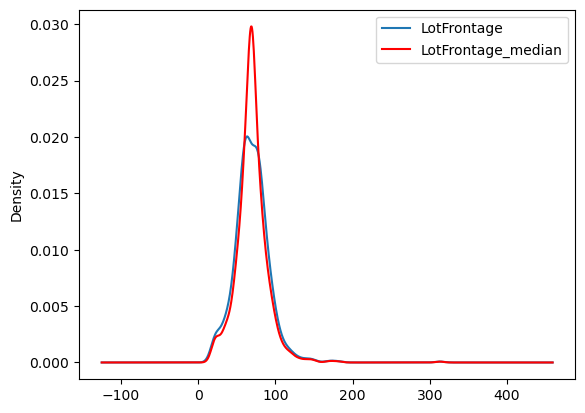

In [24]:
# let's evaluate the effect of median imputation on the distribution

# we can see that the distribution has changed for LotFrontAge
# with now more values accumulating towards the median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['LotFrontage_median'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

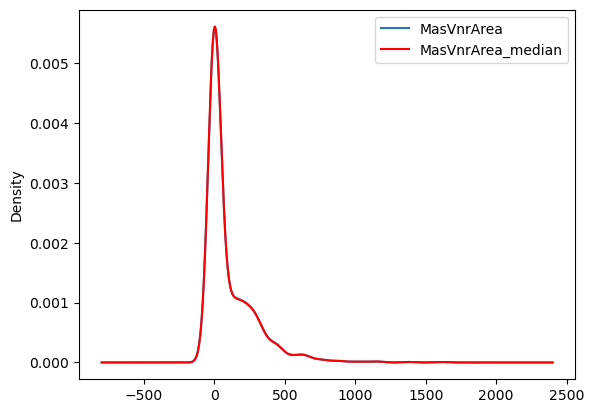

In [25]:
# For MasVnrArea, because the percentage of missing data
# was low, we don't expect and won't see a dramatic change in the
# original distribution of the variable

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['MasVnrArea_median'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

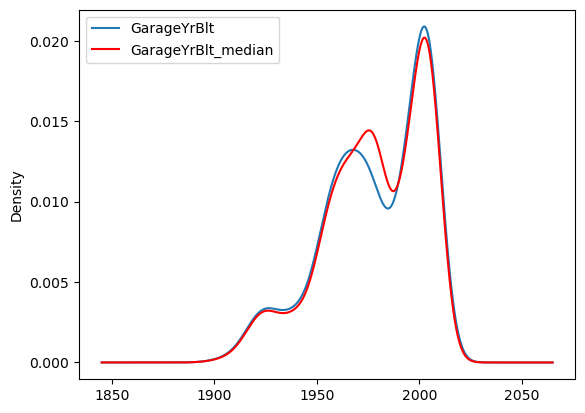

In [26]:
# similarly, for GarageBlt, because the percentage of missing data
# was low, we don't expect a massive change in the
# original distribution of the variable, however we see more values
# at around the median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['GarageYrBlt'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['GarageYrBlt_median'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [27]:
# similarly we can explore the effect of the imputation technique on 
# the variance

# we can see a change in the variance after imputation for LotFrontAge
# this is expected, because the percentage of missing data is quite
# high ~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after median imputation: ', X_train['LotFrontage_median'].var())

Original Variance:  532.5872021885676
Variance after median imputation:  434.06604265416564


In [28]:
# this is not the case for MasnVnrArea, because the % of missing data was small
print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after median imputation: ', X_train['MasVnrArea_median'].var())

Original Variance:  32983.538710039466
Variance after median imputation:  32874.27007404175


In [29]:
# for GarageBlt, the % of missing data was small so the effect
# on the variance will also be small

print('Original Variance: ', X_train['GarageYrBlt'].var())
print('Variance after median imputation: ', X_train['GarageYrBlt_median'].var())

Original Variance:  624.3059475074134
Variance after median imputation:  591.3356883144767


In [30]:
# finally, let's explore the covariance:
# take your time to compare the values in the table below.
# see how the covariance is affected for LotFrontAge but not
# so much for the other 2 variables

X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_median,MasVnrArea_median,GarageYrBlt_median
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.744233e+02,28.095264
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,5.384774,1.005330e+02,16.875386
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,553.921303,3.298354e+04,1134.380889
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,788.095358,7.472110e+03,1724.141544
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2370.929189,2.465436e+04,2989.473391
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,2750.747094,2.080136e+04,1890.271636
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3189.685753,3.496714e+04,2576.345636
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,24.755173,1.182673e+03,624.305948
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,106.009105,3.212101e+03,627.624634
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,544838.836893,6.790442e+06,877485.418108


<AxesSubplot:>

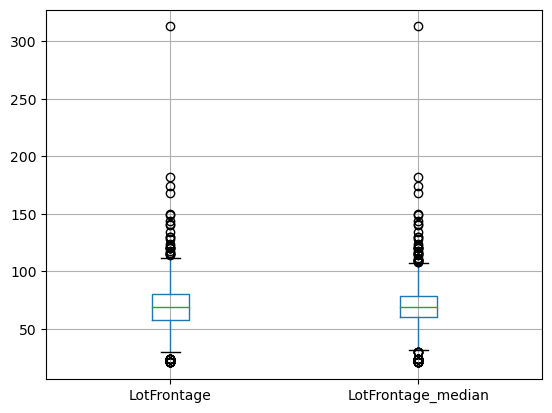

In [31]:
# Finally, let's explore the knock-on effect on outliers

# there is a decrease in the outlier boundaries for LotFrontage
# (look at the height of the top whisker)
# but not a visible effect for the other 2 variables

X_train[['LotFrontage', 'LotFrontage_median']].boxplot()

<AxesSubplot:>

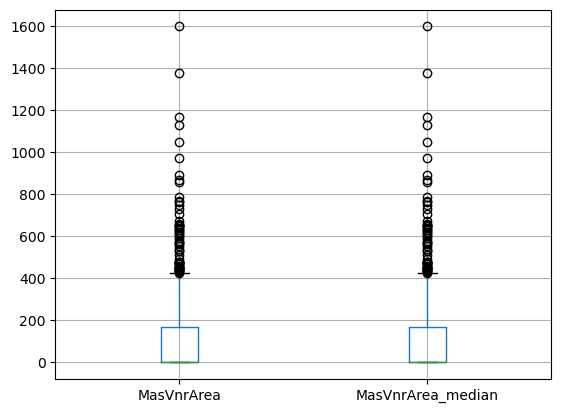

In [32]:
X_train[['MasVnrArea', 'MasVnrArea_median']].boxplot()

<AxesSubplot:>

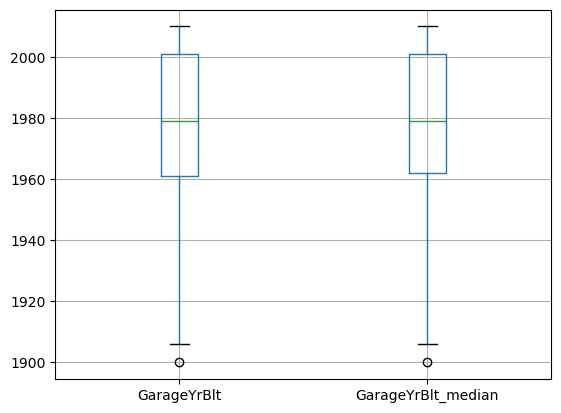

In [33]:
X_train[['GarageYrBlt', 'GarageYrBlt_median']].boxplot()